# U-Net: nuclei segmentation 1

This is an implementation of a [Kaggle kernel](https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336/notebook) of a [U-net](https://arxiv.org/abs/1505.04597) claiming to achieve a baseline score of 0.227.

In [4]:
%pwd

'/home/ubuntu/nuclei_segmentation/notebooks'

In [1]:
import os
import sys
import random
import warnings
import sklearn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

/home/ubuntu/anaconda3/envs/u_net/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tqdm import tqdm
from itertools import chain
from skimage import img_as_ubyte
from skimage.io import imread, imsave, imshow, concatenate_images
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.morphology import label, remove_small_objects, remove_small_holes, watershed
from skimage.feature import peak_local_max

from sklearn.model_selection import train_test_split

from scipy import ndimage as ndi

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [3]:
from utils.imaging import get_path, get_image_ids, label_mask, segmented_annotate, segmented_and_ground_truth_annotate
from utils.evaluate import keras_mean_iou, submit_kaggle
from utils import run_length_encoding

In [4]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

get model name form notebook name using javascript

In [5]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
notebook_name = os.path.splitext(os.path.basename(nb_name))[0]

model_name = notebook_name + '.h5'
model_path = get_path('models') + model_name

submission_name = notebook_name + '.csv'
submission_path = get_path('submission') + submission_name

### 0. Parameters

In [8]:
seed = 42

# model parameters
BATCH_SIZE = 150
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = get_path('data_train_1')
TEST_PATH = get_path('data_test_1')

test_size = 0.20

# augmentation parameters
aug_params = {
    'shear_range' : 0.7,
    'rotation_range' : 99,
    'horizontal_flip' : True,
    'vertical_flip' : True,
    'zoom_range' : 0.3,
    'width_shift_range' : 0.3,
    'height_shift_range' : 0.3,
    'fill_mode' : 'reflect'
}

### 1. Preprocess data

In [9]:
# Get train and test IDs
train_ids = get_image_ids(TRAIN_PATH)
test_ids = get_image_ids(TEST_PATH)

In [10]:
# Get and resize train images and masks
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sizes_train = []
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_train.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:53<00:00,  5.88it/s]


In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 63.44it/s]


### 2. Data augmentation

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [13]:
image_datagen = image.ImageDataGenerator(**aug_params)
mask_datagen = image.ImageDataGenerator(**aug_params)

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x = image_datagen.flow(X_train, batch_size=BATCH_SIZE, shuffle=True, seed=seed)
y = mask_datagen.flow(Y_train, batch_size=BATCH_SIZE, shuffle=True, seed=seed)

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()
image_datagen_val.fit(X_val, augment=True, seed=seed)
mask_datagen_val.fit(Y_val, augment=True, seed=seed)

x_val = image_datagen_val.flow(X_val, batch_size=BATCH_SIZE, shuffle=True, seed=seed)
y_val = mask_datagen_val.flow(Y_val, batch_size=BATCH_SIZE, shuffle=True, seed=seed)

# creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

### 3. Initialise U-Net model

In [14]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras_mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

### 4. Fit U-Net model

In [15]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
results = model.fit_generator(train_generator,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              steps_per_epoch=250,
                              epochs=3, 
                              callbacks=[earlystopper, checkpointer]
                             )

Epoch 1/3
249/250 [============================>.] - ETA: 0s - loss: 0.1599 - keras_mean_iou: 0.6118
Epoch 00001: val_loss improved from inf to 0.08226, saving model to /home/ubuntu/nuclei_segmentation/models/180316_wg_u_net_4.h5
250/250 [==============================] - 251s 1s/step - loss: 0.1596 - keras_mean_iou: 0.6123 - val_loss: 0.0823 - val_keras_mean_iou: 0.7365
Epoch 2/3
249/250 [============================>.] - ETA: 0s - loss: 0.0847 - keras_mean_iou: 0.7690
Epoch 00002: val_loss improved from 0.08226 to 0.07120, saving model to /home/ubuntu/nuclei_segmentation/models/180316_wg_u_net_4.h5
250/250 [==============================] - 240s 959ms/step - loss: 0.0847 - keras_mean_iou: 0.7691 - val_loss: 0.0712 - val_keras_mean_iou: 0.7909
Epoch 3/3
249/250 [============================>.] - ETA: 0s - loss: 0.0760 - keras_mean_iou: 0.8033
Epoch 00003: val_loss improved from 0.07120 to 0.07116, saving model to /home/ubuntu/nuclei_segmentation/models/180316_wg_u_net_4.h5
250/250 [==

### 5. Predict with U-Net model

In [16]:
# Predict on train, val and test
model = load_model(model_path, custom_objects={'keras_mean_iou': keras_mean_iou})
preds_train = model.predict(X, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 0s 3ms/step


In [17]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

# Create list of upsampled train masks
preds_train_upsampled = []
for i in range(len(preds_train)):
    preds_train_upsampled.append(resize(np.squeeze(preds_train[i]), 
                                       (sizes_train[i][0], sizes_train[i][1]), 
                                       mode='constant', preserve_range=True))

sanity check on some training examples

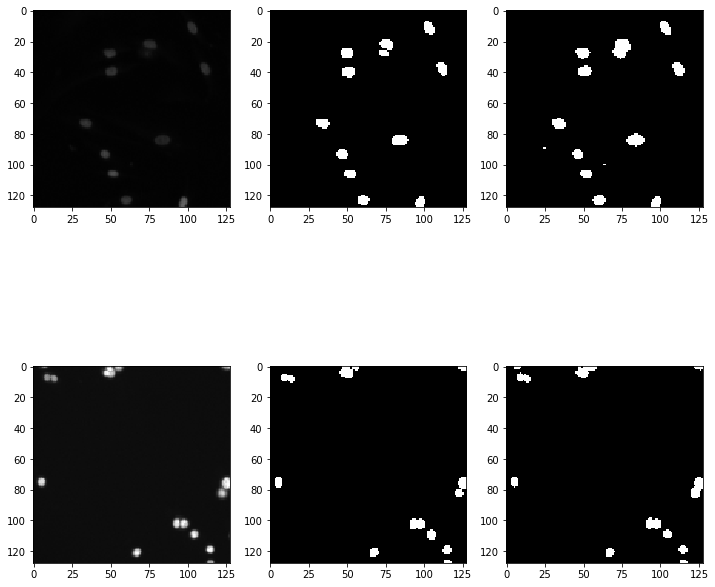

In [18]:
f, axarr = plt.subplots(2,3,figsize=(12,12))
ix1 = random.randint(0, len(preds_train_t))
ix2 = random.randint(0, len(preds_train_t))
axarr[0,0].imshow(X[ix1])
axarr[0,1].imshow(np.squeeze(Y[ix1]))
axarr[0,2].imshow(np.squeeze(preds_train_t[ix1]))
axarr[1,0].imshow(X[ix2])
axarr[1,1].imshow(np.squeeze(Y[ix2]))
axarr[1,2].imshow(np.squeeze(preds_train_t[ix2]))

### 7. Output image labels

Saving test labelled images

In [19]:
def postprocess_morphology(img):
    blobs = img > 0.5
    blobs = remove_small_holes(blobs, 20)
    distance = ndi.distance_transform_edt(blobs)
    distance = np.clip(distance - 8, 0, 255)
    markers = ndi.label(distance)[0]
    labels = watershed(-distance, markers, mask=blobs)
    blobs = blobs^find_boundaries(labels, mode='inner')
    blobs = remove_small_objects(blobs, 20)
    blobs_labels = ndi.label(blobs)[0]
    return blobs_labels

In [23]:
for idx, image_id in tqdm(enumerate(train_ids), total=len(train_ids)):
    mask = preds_train_upsampled[idx] > 0.5
    labels = postprocess_morphology(mask)
    #labels = label_mask(mask)
    imsave(get_path('output_train_1_lab_seg') + image_id + '.png', labels)

for idx, image_id in tqdm(enumerate(test_ids), total=len(test_ids)):
    mask = preds_test_upsampled[idx] > 0.5
    labels = postprocess_morphology(mask)
    imsave(get_path('output_test_1_lab_seg') + image_id + '.png', labels)

100%|██████████| 65/65 [00:02<00:00, 25.06it/s]


Saving test annotated images

In [24]:
segmented_annotate(image_type = 'test')

100%|██████████| 65/65 [00:31<00:00,  2.05it/s]


In [22]:
segmented_and_ground_truth_annotate(stage_num = 1)

100%|██████████| 670/670 [12:46<00:00,  1.14s/it]


### 8. Kaggle submit

In [25]:
df = run_length_encoding.rle_images_in_dir(image_type = 'test', stage_num = 1)
df.to_csv(submission_path, index=False)

100%|██████████| 65/65 [00:08<00:00,  8.02it/s]


In [26]:
message = "improved watershed and changed train test split method"

In [30]:
submit_string = submit_kaggle(notebook_name, submission_path, message)

In [31]:
!$submit_string

0.276
